### Imports e carregamento dos dados

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

In [ ]:
train_data = pd.read_csv('drive/My Drive/Colab Google/Tarefa DL 4/dataset_images_minitest.csv', sep='\s',engine='python')
train_data.head()

,filename,category
0,1007270_99118848fd.jpg,graduation
1,1007274_075d925378.jpg,graduation
2,1009219698_b40b9e6d87.jpg,graduation
3,10100422_0feca68bfb.jpg,graduation
4,10100587_48faabb61a.jpg,graduation


### Cross Validation

In [ ]:
Y = train_data['category']

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True,) 

Y.head()

0    graduation
1    graduation
2    graduation
3    graduation
4    graduation
Name: category, dtype: object

In [ ]:
idg = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
image_dir = 'drive/My Drive/Colab Google/Tarefa DL 4/data_folder'

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

Found 16789 validated image filenames belonging to 3 classes.
Found 4198 validated image filenames belonging to 1 classes.
Epoch 1/5
525/525 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.4486 
Epoch 00001: val_accuracy improved from -inf to 0.06027, saving model to /saved_models/model_1.h5
525/525 [==============================] - 15519s 30s/step - loss: 2.3017 - accuracy: 0.4486 - val_loss: 4.9210 - val_accuracy: 0.0603
Epoch 2/5
525/525 [==============================] - ETA: 0s - loss: 1.3349 - accuracy: 0.4700
Epoch 00002: val_accuracy improved from 0.06027 to 0.23678, saving model to /saved_models/model_1.h5
525/525 [==============================] - 438s 835ms/step - loss: 1.3349 - accuracy: 0.4700 - val_loss: 3.8472 - val_accuracy: 0.2368
Epoch 3/5
525/525 [==============================] - ETA: 0s - loss: 1.0446 - accuracy: 0.5104
Epoch 00003: val_accuracy did not improve from 0.23678
525/525 [==============================] - 444s 847ms/step - loss: 

OSError: ignored

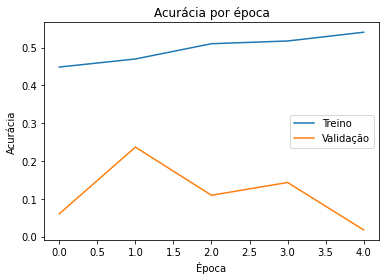

In [ ]:
import tensorflow

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(len(Y)),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "category",
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "category",
							class_mode = "categorical", shuffle = True)
	
	#Cria o modelo
	model = keras.models.Sequential([Flatten(),
                                  Dense(64, activation='relu'),
                                  Dense(32, activation='relu'),
                                  Dense(3, activation='softmax')
  ])

	model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

	
	# Cria Callbacks
	checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	
  #Treinamento do modelo
	history = model.fit(train_data_generator,
			    epochs=5,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator,
					batch_size = 605)
 
	#Plottar acurácia
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('Acurácia por época')
	plt.xlabel('Época')
	plt.ylabel('Acurácia')
	plt.legend(['Treino', 'Validação'])

	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tensorflow.keras.backend.clear_session()
	
	fold_var += 1

for i in range(len(VALIDATION_ACCURACY)):
  print(f'Model {i+1} - Accuracy: {VALIDATION_ACCURACY[i]} - Loss: {VALIDATION_LOSS[i]}')